# Checking out DESeq2 for Gene-level Differential analysis

Using mm9 genome so that the results can be more directly comparable to tables produced by elphege. We can see similarities and differences in the methods used for producing data relevant to DE analysis. 

In [1]:
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGe

In [2]:
library("tximport")
library("rhdf5")
library(stringr)
library(dplyr)

In [3]:
# get location of kallisto outputs
elphege_proj_files = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652"
sample_id <- dir(file.path(elphege_proj_files,"SRP106652"))
kal_dirs <- file.path(elphege_proj_files, "SRP106652", sample_id, "kallisto-mm9")
files <- file.path(kal_dirs, "abundance.h5")
names(files) <- str_split_fixed(files,'/',9)[,7]


In [4]:
# load conversion between transcripts and genes
ensembl_dir = "/project/fudenber_735/genomes/mm9/ensembl/ensembl_relational_downloads"
tx2gene <- read.csv(file.path(ensembl_dir,"biomaRt_mm9_t2g.csv"))[,-1]

In [36]:
# Getting "Run" and "condition" from Experiment Name of the SRA deposits
sra_summary <- read.table(
                    file.path(elphege_proj_files, 
                             "metadata", "sra_result_summary.csv"), 
                              header = TRUE, sep = ",", stringsAsFactors=FALSE)

# # Parse experiment name to get 'condition' -- str_split_fixed(string, pattern, n)
# # also Removing replicate number so that sleuth can do some grouping

conditions = data.frame(
                condition=str_split_fixed( str_split_fixed(
                             sra_summary$Experiment.Title,
                             "seq_", 4)[,2] ,'_rep',2)[,1])

sra_summary <- cbind(sra_summary,  conditions)
    
    
run_info <- read.table(file.path(elphege_proj_files, "metadata", "SraRunInfo.csv"), header = TRUE, sep = ",", stringsAsFactors=FALSE)

# # merge sra_result file and sraRunInfo to get the condition
# # (buried in 'Experiment Name' in sra_result_summary -- put in 'condition')
sra_info_combined <- merge(run_info, sra_summary, 
                             by.x=c("Experiment"),
                             by.y=c("Experiment.Accession"),
                             all.x=TRUE)

s2c <- dplyr::select(sra_info_combined, Experiment, Run, condition, Library.Strategy, Library.Selection)
s2c <- dplyr::select(s2c, sample = Run, condition)
s2c$condition <- gsub('-', '_', s2c$condition) # apparently R wants  of factors in the design to only have letters, numbers, '_' and '.'
s2c$condition <- as.factor(s2c$condition)        # Convert character column to factor (not necessary, just suppresses warning below)

In [37]:
s2c_untreated_vs_auxin1day <- s2c[ (s2c$condition=='CTCF_AID_untreated') | 
                               (s2c$condition=='CTCF_AID_auxin1day') , ]
files_untreated_vs_auxin1day =   files[untreated_vs_auxin1day$sample]

In [56]:
#s2c_untreated_vs_auxin1day$condition
s2c_untreated_vs_auxin1day$condition <-  factor(s2c_untreated_vs_auxin1day$condition,
                                                levels = c("CTCF_AID_untreated", "CTCF_AID_auxin1day"))

## to note from DESeq2:
# if you never tell the DESeq2 functions which level you want to compare against 
# (e.g. which level represents the control group), the comparisons will be based
# on the alphabetical order of the levels

[1] CTCF_AID_untreated CTCF_AID_auxin1day CTCF_AID_untreated CTCF_AID_auxin1day
[5] CTCF_AID_untreated CTCF_AID_auxin1day
Levels: CTCF_AID_untreated CTCF_AID_auxin1day

In [29]:
tx_by_genes <- tximport(
                 files_untreated_vs_auxin1day,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )

# note: transcript-level loading can also be done with tximport
#txi <- tximport( files, type="kallisto", txOut=TRUE)

1 
2 
3 
4 
5 
6 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



In [57]:
dds <- DESeqDataSetFromTximport(tx_by_genes,
                                colData = s2c_untreated_vs_auxin1day,
                                design = ~ condition)

using counts and average transcript lengths from tximport



In [58]:
dds <- DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [60]:
head(results(dds), 3)

log2 fold change (MLE): condition CTCF AID auxin1day vs CTCF AID untreated 
Wald test p-value: condition CTCF AID auxin1day vs CTCF AID untreated 
DataFrame with 3 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat    pvalue
                   <numeric>      <numeric> <numeric> <numeric> <numeric>
ENSMUSG00000000001   4942.46     -0.0335511  0.236434 -0.141905  0.887155
ENSMUSG00000000003      0.00             NA        NA        NA        NA
ENSMUSG00000000028   2278.34     -0.0913826  0.163252 -0.559764  0.575640
                        padj
                   <numeric>
ENSMUSG00000000001  0.999818
ENSMUSG00000000003        NA
ENSMUSG00000000028  0.999818

In [72]:
res <- results(dds, name='condition_CTCF_AID_auxin1day_vs_CTCF_AID_untreated')

In [73]:
res05 <- results(dds, alpha=0.05)


In [74]:
summary(res05)


out of 22072 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 130, 0.59%
LFC < 0 (down)     : 159, 0.72%
outliers [1]       : 86, 0.39%
low counts [2]     : 5504, 25%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



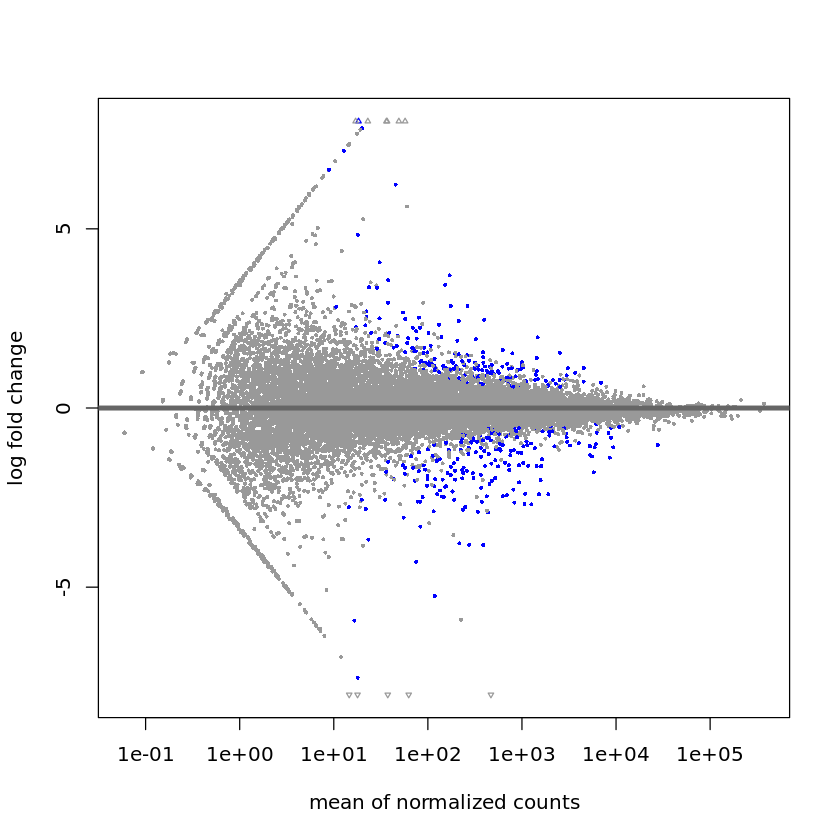

In [75]:
plotMA(res, ylim=c(-8,8))


In [80]:
tx_by_genes_all <- tximport(
                 files,
                 type = "kallisto", 
                 tx2gene = tx2gene, 
                 ignoreAfterBar = TRUE, 
                )
dds_all <- DESeqDataSetFromTximport(tx_by_genes_all,
                                colData = s2c,
                                design = ~ condition)


1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 


removing duplicated transcript rows from tx2gene

transcripts missing from tx2gene: 47421

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximport



In [84]:
vsd_all <- vst(dds_all, blind=FALSE)


using 'avgTxLength' from assays(dds), correcting for library size



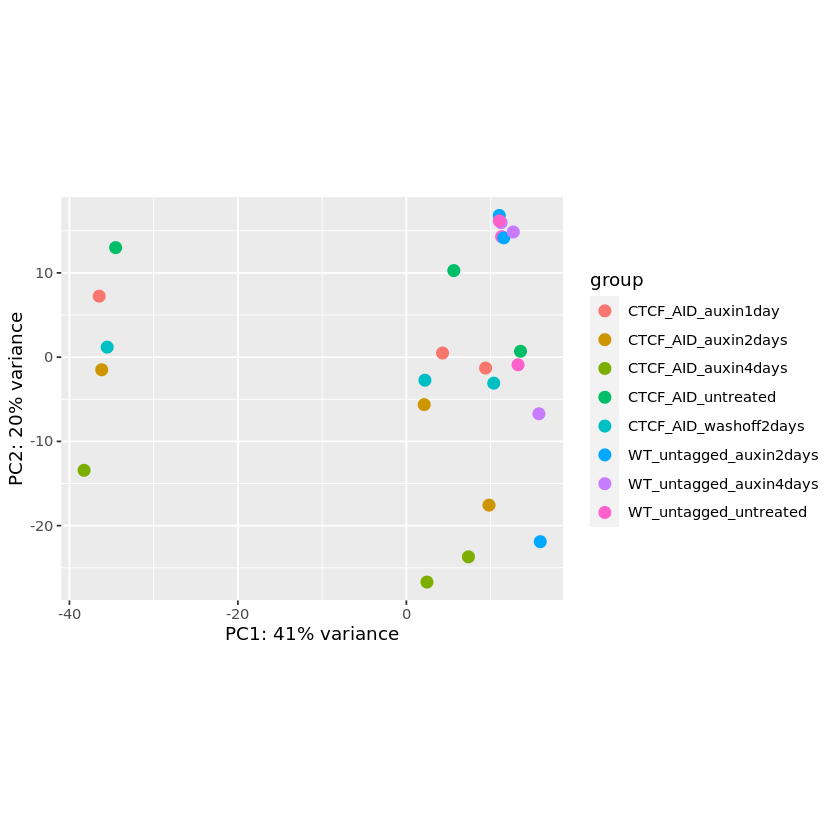

In [85]:
plotPCA(vsd_all)